<a href="https://colab.research.google.com/github/Sudharshanbhardwaj/ML-prerequisite/blob/main/retriever_basic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Retriever Augmented Generation (RAG) Demo

**Idea** Provide an LLM with access to a specific document, such that it produces answer based explicitly on the provided document.

**Motivation** There are several reasons why an RAG system may be used. Most prominent ones include the following-
- Bypass an LLM's inherent Token limit
- Give the LLM access to your proprietary knowledge, without explicitly training the LLM on your data



## INSTALLATIONS

In [ ]:
!pip -q install tiktoken openai chromadb pypdf #sentence_transformers InstructorEmbedding faiss-cpu
!pip install langchain==0.1.14

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.7/320.7 kB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 526.8/526.8 kB 27.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.4/290.4 kB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 48.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 65.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.9/59.9 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.0/107.0 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━

## SECRET KEY DECLARATION AND IMPORTS

In [ ]:
import os

# os.environ["OPENAI_API_KEY"] = "secret-key"

from google.colab import userdata
os.environ["OPENAI_API_KEY"] = userdata.get('openai')
#os.environ["GOOSEAI_API_KEY"] =  userdata.get('zeeshanGooseAI')


In [ ]:
import numpy as np
import os
import time
from PIL import Image
import random
from langchain.agents import ZeroShotAgent, Tool, AgentExecutor, initialize_agent
from langchain.prompts import PromptTemplate
from langchain.chat_models import ChatOpenAI
from langchain.agents.agent_types import AgentType
import pandas as pd
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.vectorstores import Chroma
from langchain.text_splitter import RecursiveCharacterTextSplitter, CharacterTextSplitter
from langchain.llms import OpenAI
from langchain.chains import RetrievalQA, LLMChain
from langchain.document_loaders import TextLoader, PyPDFLoader
from langchain.document_loaders import DirectoryLoader
import re

## RAG DEFINITION

In [ ]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


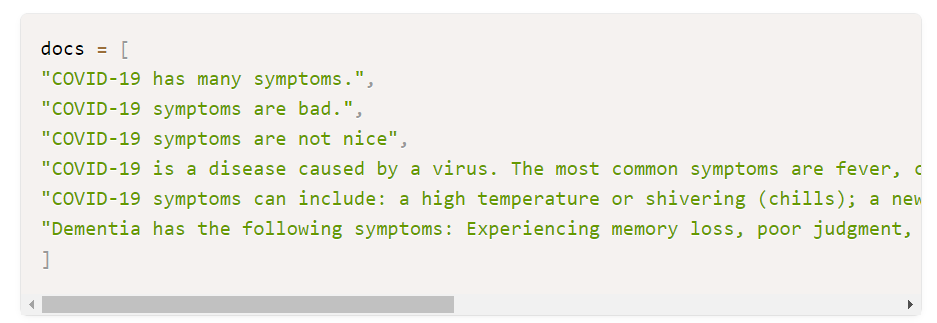

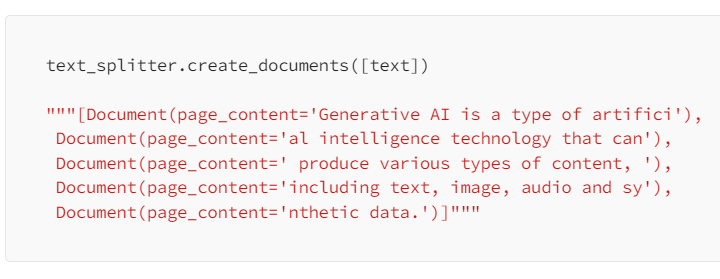

To explore
- Temperature
- Model
- Chunking strategy
- Search strategy

In [ ]:
embeddings = OpenAIEmbeddings(model="text-embedding-3-large", openai_api_key=os.environ['OPENAI_API_KEY'])

persist_dir = 'policy_txt_embeds'
#text_loader_kwargs={'autodetect_encoding': True}

loader = DirectoryLoader('/content/drive/MyDrive/handson-genai', glob="./*.pdf", loader_cls=PyPDFLoader)  # ./*.pdf , loader_kwargs=text_loader_kwargs
documents = loader.load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=2048)#CharacterTextSplitter(chunk_size=2048, chunk_overlap=128) #   , streaming=True, callbacks=[StreamingStdOutCallbackHandler()])
texts = text_splitter.split_documents(documents)

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 0.3.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import OpenAIEmbeddings`.
  warn_deprecated(


In [ ]:
print(type(texts))
print(len(texts))

<class 'list'>
50


In [ ]:
texts[1]

Document(page_content="2022 FORD F-150® caribe.ford.com \ncentroamerica.ford.com\n ®XLT SUPERCREW® 4x4 . Rapid Red Metallic Tinted Clearcoat.1 Available Chrome Package. Available equipment.\n1. Additional charge. 2.  Max. towing of 6,350 kg available on XL SuperCab ™ 8' box 4x2 and SuperCrew 6.5' box 4x2 configurations with \nthe available 3.5L EcoBoost® engine and available Max. Trailer Tow Package (not shown). Max. towing varies based on cargo, vehicle \nconfiguration, accessories and number of passengers. 3.  Horsepower, torque, payload and towing are independent attributes and may \nnot be achieved simultaneously. 4.  Max. payload of 1,508 kg available on XL Regular Cab 8' box 4x2 with available 5.0L V8 engine and \navailable Max. Trailer Tow and Heavy-Duty Payload Packages (not shown). Max. payload varies and is based on accessories and vehicle \nconfiguration. See label on door jamb for carrying capacity of a specific vehicle. 5.  Max. horsepower based on the available High-Outpu

In [ ]:
texts[1].page_content

"2022 FORD F-150® caribe.ford.com \ncentroamerica.ford.com\n ®XLT SUPERCREW® 4x4 . Rapid Red Metallic Tinted Clearcoat.1 Available Chrome Package. Available equipment.\n1. Additional charge. 2.  Max. towing of 6,350 kg available on XL SuperCab ™ 8' box 4x2 and SuperCrew 6.5' box 4x2 configurations with \nthe available 3.5L EcoBoost® engine and available Max. Trailer Tow Package (not shown). Max. towing varies based on cargo, vehicle \nconfiguration, accessories and number of passengers. 3.  Horsepower, torque, payload and towing are independent attributes and may \nnot be achieved simultaneously. 4.  Max. payload of 1,508 kg available on XL Regular Cab 8' box 4x2 with available 5.0L V8 engine and \navailable Max. Trailer Tow and Heavy-Duty Payload Packages (not shown). Max. payload varies and is based on accessories and vehicle \nconfiguration. See label on door jamb for carrying capacity of a specific vehicle. 5.  Max. horsepower based on the available High-Output \n3.5L EcoBoost engi

In [ ]:
for i in range(len(texts)):
  print(len(texts[i].page_content))

searching in chunks
- Similarity
- MMR (Maximum Maeginal Relevance)

In [ ]:
docsearch = Chroma.from_documents(texts, embeddings, persist_directory=persist_dir)

qa = RetrievalQA.from_chain_type(llm = ChatOpenAI(model = "gpt-4o", temperature=0.9), chain_type='stuff', retriever=docsearch.as_retriever(search_type="similarity", search_kwargs={'k': 5}, return_source_documents = True))

In [ ]:
qa("whats the workbench thing")

{'query': 'whats the workbench thing',
 'result': 'The workbench feature on the 2022 Ford F-150 is a built-in Tailgate Work Surface. It is designed to make it easier to set up shop wherever you take your truck. This surface includes various useful holders molded into the durable composite material with a grained texture to help keep work in place. The workbench includes features such as:\n\n- **Media Holder**: Props up your smartphone or tablet for easy viewing.\n- **Cup/Hardware Holder**: Keeps your beverage of choice within reach.\n- **Utility Tray**: For storing small parts.\n- **Clamp Pockets**: Spring-loaded doors to help shut out water and debris, allowing for a wider range of tasks.\n- **Dual Rulers**: For quick measurements without a tape measure.\n- **Flat Surface**: Provides a sizable work area clear of the truck bed.\n- **Tie-Down Hooks**: Offer more anchor points to help secure cargo across the tailgate, which also double as bottle openers. \n\nThis feature is available on 

The Ford F-150 features an available Tailgate Work Surface that is designed to enhance productivity when using the truck for work-related tasks. This durable composite surface includes a variety of useful holders and features molded into it, such as:

- **Cup/Hardware Holder:** Keeps your beverage or small tools within easy reach.
- **Utility Tray:** Ideal for holding small parts.
- **Clamp Pockets:** These have spring-loaded doors to help keep out water and debris.
- **Dual Rulers:** Integrated into the surface for quick measurements.
- **Flat Surface:** Provides a clear and sizable work area on the tailgate.
- **Tailgate Tie-Down Hooks:** These offer additional anchor points to help secure cargo and can also function as bottle openers.

This built-in workbench makes it easier to set up a workspace wherever you take your Ford F-150, enhancing the truck's utility for a wide range of tasks.

The 2022 Ford F-150 offers several engine variants, each with different power outputs:

1. **3.3L Ti-VCT V6**
   - 290 Max. HP
   - 265 lb.-ft. Max. Torque

2. **5.0L Ti-VCT V8**
   - 400 Max. HP
   - 410 lb.-ft. Max. Torque

3. **3.5L EcoBoost V6**
   - 400 Max. HP
   - 500 lb.-ft. Max. Torque

4. **3.5L PowerBoost Full Hybrid V6**
   - 430 Max. HP
   - 570 lb.-ft. Max. Torque

These are the main engine options available for the 2022 Ford F-150, each offering a unique balance of power and torque to cater to different driving needs and preferences.

The research utilized two datasets for their experiments, each serving a specific purpose in the context of domain adaptation and localization tasks. Here are the details of each dataset as mentioned:\n\n1. **UJI Dataset**: Although the text does not provide an explicit description of the UJI dataset, it is referenced in the context of computing Proxy A-distance (PAD) values for adaptation tasks. The UJI dataset is used to demonstrate the application of the domain adaptation method over time, specifically from month 1 to month 10. The PAD values computed on this dataset serve to illustrate the effectiveness of the domain adaptation method in reducing the discrepancy between source and target domains over time. The specific characteristics of the UJI dataset, such as the type of data it contains or its size, are not detailed in the provided text.\n\n2. **KIOS Dataset**: The KIOS WiFi RSS dataset is described in detail. It was acquired in the KIOS research center, covering an area of 560 square meters. The dataset comprises Received Signal Strength (RSS) values collected using five different devices: iPAQ, eeePC, HTC Flyer, HTC Desire, and Nexus. This dataset is particularly suited for device transfer learning tasks, where one device is considered the source domain and another the target domain. For instance, the HTC Desire could be the source, and the Nexus could be the target. Each device in the dataset includes 2100 training samples and 960 test samples, with RSS measurements recorded from all available Access Points (APs) at 105 distinct reference locations. The dataset also features a varying number of APs in different parts of the floor, making it ideal for studying device transfer learning and domain adaptation in wireless localization tasks. A substitution value of -100dB is chosen for undetected APs to handle missing data.\n\nThese datasets, UJI and KIOS, are utilized to test and validate the effectiveness of domain adaptation techniques, specifically in the context of reducing the discrepancy between different domains (e.g., different devices or time periods) to improve localization accuracy in wireless networks.